In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K


def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=3)  # 3 classes (0, 1, 2)
        
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * tf.math.log(y_pred)
        loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=1))
    return focal_loss_fixed


# Paths
TRAIN_DIR = './Train'
TEST_DIR = './Test'
LABELS_FILE = './label_train.csv'

In [2]:
# Load labels
labels_df = pd.read_csv(LABELS_FILE)

# Load training data
def load_data(directory, labels_df):
    X = []
    y = []
    for idx, row in labels_df.iterrows():
        file_name = f"{row['ID']}.npy"
        file_path = os.path.join(directory, file_name)
        sample = np.load(file_path)
        X.append(sample)
        y.append(row['target'])
    return np.array(X), np.array(y)

X, y = load_data(TRAIN_DIR, labels_df)

print(f"Training data shape: {X.shape}")

Training data shape: (1491, 72, 48)


In [3]:
# Normalize data
X = (X - np.mean(X)) / np.std(X)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Expand dimensions if needed (add channel dimension)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Automatically calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [ ]:
# Build the CNN model
def build_model():
    model = keras.Sequential([
        layers.Input(shape=(72, 48, 1)),
        
        layers.Conv2D(64, (3, 2), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 2), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 2), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        
        layers.Dense(32, activation='relu'),

        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 70, 47, 64)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 35, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 33, 22, 128)    │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 10, 64)     │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       143,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,803 (956.26 KB)

 Trainable params: 244,675 (955.76 KB)

 Non-trainable params: 128 (512.00 B)

In [5]:
# Data augmentation (optional)
data_gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

In [6]:
# Train the model
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=20),
    validation_data=(X_val, y_val),
    epochs=30,
    class_weight=class_weights_dict, 
    callbacks=[
        keras.callbacks.EarlyStopping(patience=9, monitor='val_loss', verbose=1, restore_best_weights=True),
        # keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
    ]
)

Epoch 1/30


c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4686 - loss: 1.0263 - val_accuracy: 0.8662 - val_loss: 0.4938
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6455 - loss: 0.8534 - val_accuracy: 0.8896 - val_loss: 0.4037
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7392 - loss: 0.7051 - val_accuracy: 0.8997 - val_loss: 0.3163
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8077 - loss: 0.4238 - val_accuracy: 0.9766 - val_loss: 0.1160
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8559 - loss: 0.4141 - val_accuracy: 0.8829 - val_loss: 1.0827
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8841 - loss: 0.3084 - val_accuracy: 0.8863 - val_loss: 0.7747
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8961 - loss: 0.3548 - val_accuracy: 0.9298 - val_loss: 0.1321
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9203 - loss: 0.1954 - val_accuracy: 0.8963 - val_loss: 0.

In [7]:
# Load test data
def load_test_data(directory):
    files = sorted(os.listdir(directory), key=lambda x: int(x.split('.')[0]))
    X_test = []
    file_names = []
    for file in files:
        file_path = os.path.join(directory, file)
        sample = np.load(file_path)
        X_test.append(sample)
        file_names.append(file.split('.')[0])
    return np.array(X_test), file_names

X_test, test_file_names = load_test_data(TEST_DIR)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)
X_test = np.expand_dims(X_test, axis=-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
10/10 - 0s - 7ms/step - accuracy: 0.9866 - loss: 0.0386
Validation Accuracy: 0.9866
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


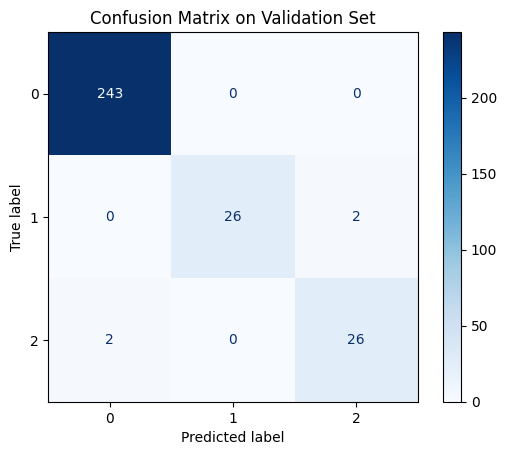

In [8]:
# Predict
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predict on validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Validation Set')
plt.show()

In [9]:
# Save for Kaggle
submission = pd.DataFrame({
    'ID': test_file_names,
    'target': predicted_labels
})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv
